### Here we build a ann that can beat RF in adult dataset which has mainly tabular data in it.

In [2]:
import numpy as np
import pandas as pd

from fastai.tabular.all import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

path = untar_data(URLs.ADULT_SAMPLE)

df = pd.read_csv(path/'adult.csv')
sel_obj = make_column_selector(dtype_include=[object, 'category'])
sel_cont = make_column_selector(dtype_include=np.number)

df.loc[:, sel_obj(df)] = df.loc[:, sel_obj(df)].astype('category') 

# Fillnans
df.fillna(method='bfill', inplace=True)

# There are additional spaces everyeher..
for c in sel_obj(df):
    df.loc[:, c] = df.loc[:, c].map(lambda s: s.strip())


ord_dict = np.load('cat_feature_order_dict.npy', allow_pickle=True).item()
for key in ord_dict.keys():
    feat_order = ord_dict[key].items()
    cats = np.array(sorted(feat_order, key=lambda t: t[1]))[:, 0]
    df.loc[:, key].cat.set_categories(cats, ordered=True, inplace=True)

# Transformers
nn_cat_pipe = Pipeline([('ordinal', OrdinalEncoder()), ('std', StandardScaler())])
ct = ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(), sel_obj)], remainder='passthrough')
ct_nn = ColumnTransformer(transformers=[('ordinal+std', nn_cat_pipe, sel_obj), 
                                        ('standard', StandardScaler(), sel_cont)], 
                          remainder='passthrough')

# Train test split
y = df.loc[:, 'salary']
df = df.drop(columns='salary')
X_train, X_valid, y_train, y_valid  = train_test_split(df, y)

X_train_enc = ct.fit_transform(X_train)
X_valid_enc = ct.transform(X_valid)
X_train_nn = ct_nn.fit_transform(X_train)
X_valid_nn = ct_nn.transform(X_valid)

train_idxs = X_train.index.values
valid_idxs = X_valid.index.values


In [5]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(pd.concat((df, y), axis=1), procs=procs_nn, 
                      cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                      cont_names = ['age', 'fnlwgt', 'education-num'],
                      y_names="salary",
                      splits=(list(train_idxs), list(valid_idxs)))

dls = to_nn.dataloaders(24)
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,age,fnlwgt,education-num,salary
0,Private,Some-college,Never-married,Exec-managerial,Not-in-family,White,36.000000,109133.001277,10.0,<50k
1,Private,Assoc-voc,Married-civ-spouse,Adm-clerical,Husband,White,47.000000,200470.999947,11.0,<50k
2,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,45.000000,185385.000133,9.0,>=50k
3,State-gov,Bachelors,Never-married,Adm-clerical,Own-child,White,22.000000,292933.001878,13.0,<50k
4,Local-gov,Bachelors,Divorced,Prof-specialty,Unmarried,White,34.000000,255098.002512,13.0,<50k
5,Private,HS-grad,Separated,Adm-clerical,Unmarried,Black,30.000000,228405.999415,9.0,<50k
6,Self-emp-not-inc,Bachelors,Married-civ-spouse,Farming-fishing,Husband,White,83.999999,155057.000429,13.0,<50k
7,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,White,36.000000,166416.000141,9.0,<50k
8,Private,Some-college,Divorced,Exec-managerial,Own-child,Black,38.000000,191479.000064,10.0,<50k
9,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Wife,White,33.000000,403467.990469,9.0,<50k


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.25118863582611084)

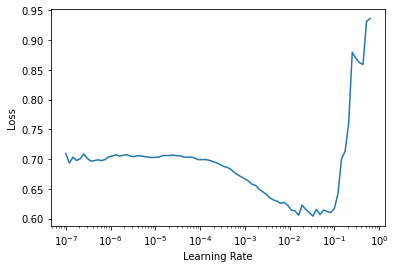

In [6]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()


In [7]:
learn.fit_one_cycle(5, lr=.0005)

epoch,train_loss,valid_loss,accuracy,time
0,0.393522,0.365058,0.828399,00:08
1,0.364926,0.349920,0.834787,00:08
2,0.362898,0.348167,0.842280,00:07
3,0.348620,0.342484,0.843754,00:08
4,0.329532,0.341860,0.843140,00:07


In [8]:
from sklearn.metrics import accuracy_score, classification_report
rf = RandomForestClassifier(n_estimators=200, oob_score=True)
rf.fit(X_train_enc, y_train)

y_pred = rf.predict(X_valid_enc)

print(classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

        <50k     0.8886    0.9286    0.9082      6235
       >=50k     0.7262    0.6191    0.6684      1906

    accuracy                         0.8562      8141
   macro avg     0.8074    0.7739    0.7883      8141
weighted avg     0.8506    0.8562    0.8520      8141



### RF is almost completely able to tell whether a given instance is from the validation set or from the training set!?

In [9]:
is_valid = np.zeros(len(df), dtype=bool)
is_valid[valid_idxs] = True

df_enc = ct.fit_transform(df)

rf.fit(df_enc, is_valid)
print(rf.oob_score_)
y_pred = rf.predict(df_enc)
print(classification_report(is_valid, y_pred, digits=4))

0.7335462670065416
              precision    recall  f1-score   support

       False     0.9998    1.0000    0.9999     24420
        True     1.0000    0.9993    0.9996      8141

    accuracy                         0.9998     32561
   macro avg     0.9999    0.9996    0.9998     32561
weighted avg     0.9998    0.9998    0.9998     32561



In [10]:
y_pred =  np.where(is_valid, rf.oob_decision_function_[:, 0], rf.oob_decision_function_[:, 1]) > .5
print(classification_report(is_valid, y_pred, digits=4))

              precision    recall  f1-score   support

       False     0.9891    0.9683    0.9786     24420
        True     0.9107    0.9681    0.9385      8141

    accuracy                         0.9683     32561
   macro avg     0.9499    0.9682    0.9586     32561
weighted avg     0.9695    0.9683    0.9686     32561



In [11]:
sorted(zip(df.columns, rf.feature_importances_), key=lambda t: t[1], reverse=True)

[('sex', 0.2876446446199688),
 ('race', 0.1883671018296292),
 ('native-country', 0.11617412359950822),
 ('education', 0.09092459971271796),
 ('capital-gain', 0.050625637680229686),
 ('workclass', 0.048782501151142944),
 ('age', 0.04379067017813781),
 ('education-num', 0.03811328550832922),
 ('fnlwgt', 0.033927029235614664),
 ('relationship', 0.02438402115592836),
 ('capital-loss', 0.023205472187463532),
 ('marital-status', 0.023059999420491768),
 ('hours-per-week', 0.01652401216227622),
 ('occupation', 0.014476901558561728)]